In [1]:
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
instant_files = sorted(glob.glob("era5_*/data_stream-oper_stepType-instant.nc"))
accum_files = sorted(glob.glob("era5_*/data_stream-oper_stepType-accum.nc"))

print(f"Instantaneous files: {len(instant_files)}")
for f in instant_files:
    print(f"  {f}  ({os.path.getsize(f)/1e6:.1f} MB)")

print(f"\nAccumulated files: {len(accum_files)}")
for f in accum_files:
    print(f"  {f}  ({os.path.getsize(f)/1e6:.1f} MB)")

Instantaneous files: 6
  era5_2015/data_stream-oper_stepType-instant.nc  (476.2 MB)
  era5_2016/data_stream-oper_stepType-instant.nc  (478.7 MB)
  era5_2017/data_stream-oper_stepType-instant.nc  (477.0 MB)
  era5_2018/data_stream-oper_stepType-instant.nc  (478.2 MB)
  era5_2019/data_stream-oper_stepType-instant.nc  (481.0 MB)
  era5_2020/data_stream-oper_stepType-instant.nc  (481.6 MB)

Accumulated files: 6
  era5_2015/data_stream-oper_stepType-accum.nc  (32.7 MB)
  era5_2016/data_stream-oper_stepType-accum.nc  (33.3 MB)
  era5_2017/data_stream-oper_stepType-accum.nc  (32.7 MB)
  era5_2018/data_stream-oper_stepType-accum.nc  (34.5 MB)
  era5_2019/data_stream-oper_stepType-accum.nc  (33.2 MB)
  era5_2020/data_stream-oper_stepType-accum.nc  (31.6 MB)


In [3]:
ds_instant = xr.open_mfdataset(instant_files, combine='by_coords')
print("=== Instantaneous ===")
print(f"Variables: {list(ds_instant.data_vars)}")
print(ds_instant)

ds_accum = xr.open_mfdataset(accum_files, combine='by_coords')
print("=== Accumulated ===")
print(f"Variables: {list(ds_accum.data_vars)}")
print(ds_accum)

=== Instantaneous ===
Variables: ['t2m', 'msl', 'u10', 'v10', 'd2m', 'sp']
<xarray.Dataset>
Dimensions:     (valid_time: 8768, latitude: 105, longitude: 281)
Coordinates:
    number      int64 0
  * valid_time  (valid_time) datetime64[ns] 2015-01-01 ... 2020-12-31T18:00:00
  * latitude    (latitude) float64 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
  * longitude   (longitude) float64 -130.0 -129.8 -129.5 ... -60.5 -60.25 -60.0
    expver      (valid_time) object dask.array<chunksize=(1460,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(1460, 105, 281), meta=np.ndarray>
    msl         (valid_time, latitude, longitude) float32 dask.array<chunksize=(1460, 105, 281), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(1460, 105, 281), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(1460, 105, 281), meta=np.ndarray>
    d2m       

In [5]:
ds = xr.merge([ds_instant, ds_accum])
print(f"Dimensions: {dict(ds.dims)}")
print(f"Variables: {list(ds.data_vars)}")
print(f"Time range: {ds.valid_time.values[0]} to {ds.valid_time.values[-1]}")
print(f"Timesteps: {len(ds.valid_time)}")
print(f"Grid size: {len(ds.latitude)} x {len(ds.longitude)}")
print(f"Lat: {ds.latitude.values.min():.2f} to {ds.latitude.values.max():.2f}")
print(f"Lon: {ds.longitude.values.min():.2f} to {ds.longitude.values.max():.2f}")

Dimensions: {'valid_time': 8768, 'latitude': 105, 'longitude': 281}
Variables: ['t2m', 'msl', 'u10', 'v10', 'd2m', 'sp', 'tp']
Time range: 2015-01-01T00:00:00.000000000 to 2020-12-31T18:00:00.000000000
Timesteps: 8768
Grid size: 105 x 281
Lat: 24.00 to 50.00
Lon: -130.00 to -60.00


In [6]:
for var in ds.data_vars:
    null_count = int(ds[var].isnull().sum().values)
    total = int(ds[var].size)
    print(f"  {var}: {null_count} NaN out of {total} ({100*null_count/total:.4f}%)")


  t2m: 0 NaN out of 258699840 (0.0000%)
  msl: 0 NaN out of 258699840 (0.0000%)
  u10: 0 NaN out of 258699840 (0.0000%)
  v10: 0 NaN out of 258699840 (0.0000%)
  d2m: 0 NaN out of 258699840 (0.0000%)
  sp: 0 NaN out of 258699840 (0.0000%)
  tp: 0 NaN out of 258699840 (0.0000%)


In [8]:
times = pd.DatetimeIndex(ds.valid_time.values)
diffs = times[1:] - times[:-1]
print("Time step frequencies:")
print(diffs.value_counts())

gaps = [(times[i], times[i+1]) for i in range(len(diffs)) if diffs[i] != pd.Timedelta(hours=6)]
if gaps:
    print(f"\n⚠️  {len(gaps)} irregular gaps:")
    for start, end in gaps[:10]:
        print(f"  {start} → {end} ({end - start})")
else:
    print("✓ All time steps are uniform (6 hours)")

Time step frequencies:
0 days 06:00:00    8767
Name: count, dtype: int64
✓ All time steps are uniform (6 hours)


In [9]:
stats = {}
for var in ds.data_vars:
    v = ds[var]
    stats[var] = {
        'min': float(v.min().values),
        'max': float(v.max().values),
        'mean': float(v.mean().values),
        'std': float(v.std().values),
    }

stats_df = pd.DataFrame(stats).T
stats_df

,min,max,mean,std
t2m,228.866440,323.788330,287.879974,11.031889
msl,95298.562500,106034.250000,101682.625000,697.664856
u10,-32.951431,31.693817,0.494279,3.694876
v10,-35.300079,32.989441,-0.174358,4.133724
d2m,225.182159,303.472656,281.394531,11.084643
sp,64809.238281,105344.187500,96707.343750,7000.911133
tp,0.000000,0.038831,0.000107,0.000466


In [10]:
os.makedirs("eda_outputs", exist_ok=True)
stats_df.to_csv("eda_outputs/variable_stats.csv")
print("Saved to eda_outputs/variable_stats.csv")

Saved to eda_outputs/variable_stats.csv


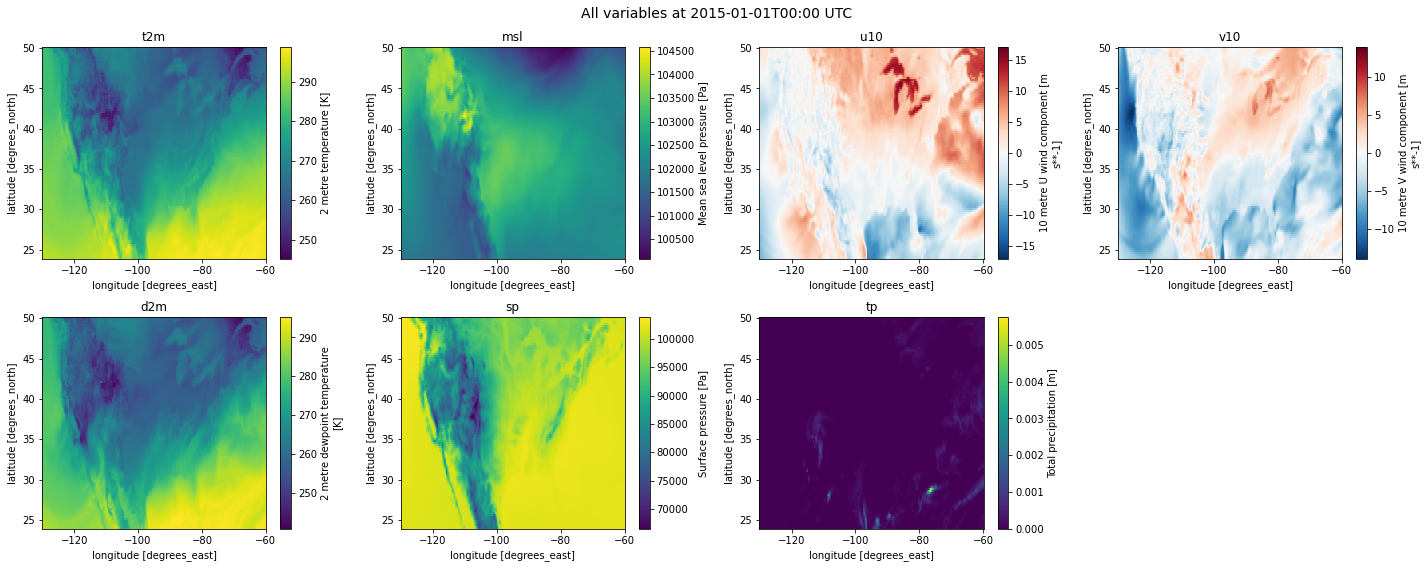

In [13]:
var_names = list(ds.data_vars)
n_vars = len(var_names)
cols = min(4, n_vars)
rows = (n_vars + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = np.array(axes).flatten()

for i, var in enumerate(var_names):
    ds[var].isel(valid_time=0).plot(ax=axes[i])
    axes[i].set_title(var)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle(f"All variables at {str(ds.valid_time.values[0])[:16]} UTC", fontsize=14)
plt.tight_layout()
plt.show()

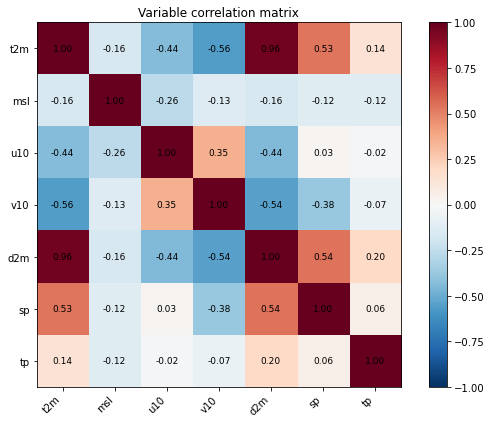

,t2m,msl,u10,v10,d2m,sp,tp
t2m,1.00,-0.16,-0.44,-0.56,0.96,0.53,0.14
msl,-0.16,1.00,-0.26,-0.13,-0.16,-0.12,-0.12
u10,-0.44,-0.26,1.00,0.35,-0.44,0.03,-0.02
v10,-0.56,-0.13,0.35,1.00,-0.54,-0.38,-0.07
d2m,0.96,-0.16,-0.44,-0.54,1.00,0.54,0.20
sp,0.53,-0.12,0.03,-0.38,0.54,1.00,0.06
tp,0.14,-0.12,-0.02,-0.07,0.20,0.06,1.00


In [16]:
sample = ds.isel(valid_time=0).to_dataframe().dropna()
corr = sample[var_names].corr()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr.values, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(len(var_names)))
ax.set_yticks(range(len(var_names)))
ax.set_xticklabels(var_names, rotation=45, ha='right')
ax.set_yticklabels(var_names)

for i in range(len(var_names)):
    for j in range(len(var_names)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center', fontsize=9)

plt.colorbar(im)
plt.title("Variable correlation matrix")
plt.tight_layout()
plt.show()

corr.round(2)